# Clustering + PCA (Exercise 23)

In [83]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("axes", titlesize=16)
plt.rc("font", size=12)
from scipy.spatial.distance import pdist,squareform
from scipy.optimize import fmin
from matplotlib.colors import to_rgba

In [107]:
from week4 import LennardJones, AtomicCluster
lennard_jones_calc = LennardJones()
from cpclasses.PlotTools import save_plot

In [85]:
class CoulombMatrixSpectrum():
    
    def __init__(self, color='C4'):
        self.xwidth = 1
        self.color = color
    
    def descriptor(self,pos):
        r_matrix = squareform(pdist(pos))
        np.fill_diagonal(r_matrix, 1)
        one_over_r_matrix = r_matrix**-1
        eigen_values, _ = np.linalg.eig(one_over_r_matrix)
        eigen_values = np.real(eigen_values) # ignore any small complex component
        sorted_eigen_values = sorted(eigen_values)
        return sorted_eigen_values

    def draw(self,pos,ax):
        vector = self.descriptor(pos)
        N = len(vector)
        xcenters = np.linspace(0,N-1,N) * self.xwidth
        ax.bar(xcenters,vector,width=0.8 * self.xwidth,color=self.color)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_ylim([-2,8])
        ax.set_title(self.__class__.__name__)
    
descriptor = CoulombMatrixSpectrum()

In [86]:
pos_flat = np.loadtxt('lj10clusters.txt')
positions_in_file = pos_flat.reshape(-1,pos_flat.shape[1]//2,2)

In [87]:
def get_rattled_copies_of_atomic_cluster_number(i):
    selected_position = positions_in_file[i]
    new_positions = [selected_position]
    for _ in range(9):
        new_positions += [selected_position + \
                          0.05 * np.random.randn(*selected_position.shape)]
    positions = np.array(new_positions)
    rattled_atomic_clusters = [AtomicCluster(lennard_jones_calc,pos=pos,
                                    descriptor_method=descriptor)\
                for pos in positions]
    return rattled_atomic_clusters

### Now rattle all the structures

In [88]:
rattled_atomic_clusters = []
for i in range(len(positions_in_file)):
    rattled_atomic_clusters += get_rattled_copies_of_atomic_cluster_number(i)

In [89]:
#pca.fit(positions_original)
#positions_transformed = pca.transform(positions_original)

### Make your PCA

In [90]:
import numpy as np

class PCA:
    def __init__(self, n_components):
        self.k = n_components

    def fit(self, X):
        M,p = X.shape
        
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        C = 1/(M-1) * np.dot(X_centered.T,X_centered)

        lambdas, Q = np.linalg.eig(C)

        eigenvalue_order = np.argsort(lambdas)[::-1]
        lambdas = lambdas[eigenvalue_order]
        Q = Q[:, eigenvalue_order]

        self.Qk = Q[:, :self.k]

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.Qk)

pca = PCA(2)

### Use your PCA on atomic clusters using their descriptors

In [91]:
descriptors_before = np.array([cluster.descriptor for cluster in rattled_atomic_clusters])
pca.fit(descriptors_before)
descriptors_after = pca.transform(descriptors_before)

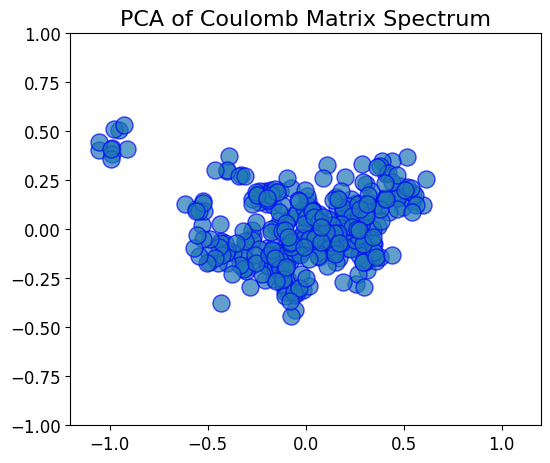

In [108]:
fig, ax = plt.subplots()

ax.scatter(descriptors_after[:,0],descriptors_after[:,1],s=150,alpha=0.7, edgecolors='b')
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1,1])
ax.set_aspect('equal')
ax.set_title('PCA of Coulomb Matrix Spectrum')

fig.tight_layout()
save_plot(fig, 'PCA_of_Coulomb_Matrix_Spectrum.png')

In [93]:
class KMeans:
    def __init__(self, n_clusters, max_iter=100, tol=1e-4):
        self.k = n_clusters  # Number of clusters
        self.max_iter = max_iter  # Maximum number of iterations
        self.tol = tol  # Tolerance for convergence

    def fit(self, X):
        # Step 1: Initialization
        M, n_features = X.shape
        random_indices = np.random.choice(M, self.k, replace=False)
        self.centroids = X[random_indices]  # Randomly initialize centroids

        for _ in range(self.max_iter):
            # Step 2: Assignment step
            #
            # About "np.newaxis":
            #
            # a = np.array([[1, 2, 3],[4, 5, 6]])
            # print(a.shape)
            # print(a[np.newaxis].shape)
            # print(a[:, np.newaxis].shape)
            # print(a[:,:, np.newaxis].shape)
            # (2, 3)
            # (1, 2, 3)
            # (2, 1, 3)
            # (2, 3, 1)
            #
            # Broadcasting:
            # X[:, np.newaxis]: [M,1,n]
            # self.centroids: [k, n]
            # (X[:, np.newaxis] - self.centroids): [M, k, n]
            # np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2): [M, k]
            # np.argmin(distances, axis=1): [M]
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            self.labels = np.argmin(distances, axis=1)

            # Step 3: Update step
            new_centroids = np.array([X[self.labels == j].mean(axis=0) for j in range(self.k)])

            # Check for convergence (if centroids don't change significantly)
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
            self.centroids = new_centroids

        return self

    def predict(self, X):
        # Assign clusters to new data points
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)



In [94]:
n_clusters=8
kmeans = KMeans(n_clusters=n_clusters)
X = descriptors_after
kmeans.fit(X)

print(kmeans.centroids)
print(kmeans.labels)

labels = kmeans.predict(descriptors_after)

print(labels)

[[ 0.41092904  0.19329474]
 [ 0.27176631 -0.03110699]
 [ 0.07945583 -0.05810738]
 [ 0.01302638  0.09835503]
 [-0.42511572 -0.07792234]
 [-0.9838393   0.43773737]
 [-0.24507513  0.20095884]
 [-0.11948273 -0.18806233]]
[4 4 4 4 4 4 6 7 7 4 5 5 5 5 5 5 5 5 5 5 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 6 6 6 6 3 3 6 6 3 6 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 7 7 7 7
 7 7 7 7 7 7 0 1 0 3 0 1 1 3 1 0 3 3 3 2 3 6 3 2 2 3 7 7 7 7 7 7 7 7 7 7 2
 2 2 2 2 2 2 2 2 1 0 1 1 0 0 1 1 0 0 1 4 4 4 4 4 4 7 7 4 4 0 0 0 1 0 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 7 7 7 7 7 7 7 7 7 7 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4
 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 3 2 1 6 6
 6 6 6 6 6 6 6 6 7 2 7 7 7 2 7 7 3 2 1 1 1 2 1 2 1 3 1 1 0 2 1 0 1 0 0 3 1
 3 1 2 2 1 1 1 1 1 3 3 2 2 3 2 2 2 3 2 3 2 3 3 3 6 3 6 3 3 2 2 4 4 4 4 4 4
 4 4 4 4 2 3 2 2 7 2 2 2 2 2 2 2 2 2 2 7 7 2 3 2 6 3 6 3 3 6 6 6 6 6 3 3 3
 3 3 2 3 2 3 3 7 7 7 7 7 7 7 7 7 7 2 2 3 2 7 3 7 2 2 7 1 1 2 1 1 0 2 1 1 1
 4 4 4 4 4 4 4 4 4 4]
[4 4 4 4 4 

In [95]:
from matplotlib.colors import ListedColormap
alpha=0.5
cmap = ListedColormap([f'C{i}' for i in [0, 1, 2, 3, 4, 8, 5, 6, 7, 9][:n_clusters]])


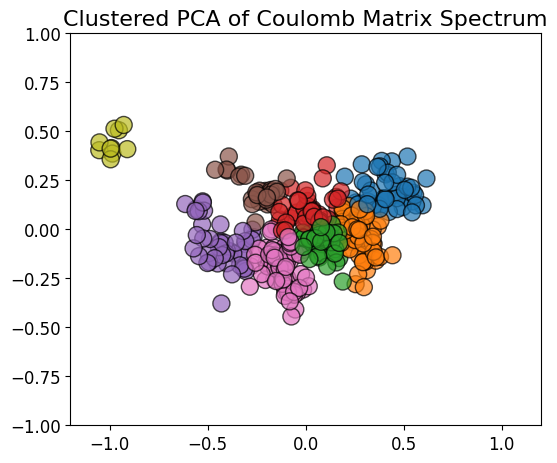

In [112]:
fig, ax = plt.subplots()

ax.scatter(descriptors_after[:,0],descriptors_after[:,1],s=150,alpha=0.7,edgecolors='black',c=cmap(labels))
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1,1])
ax.set_aspect('equal')
ax.set_title('Clustered PCA of Coulomb Matrix Spectrum')

fig.tight_layout()
save_plot(fig, 'Clustered_PCA_of_Coulomb_Matrix_Spectrum.png')

[]

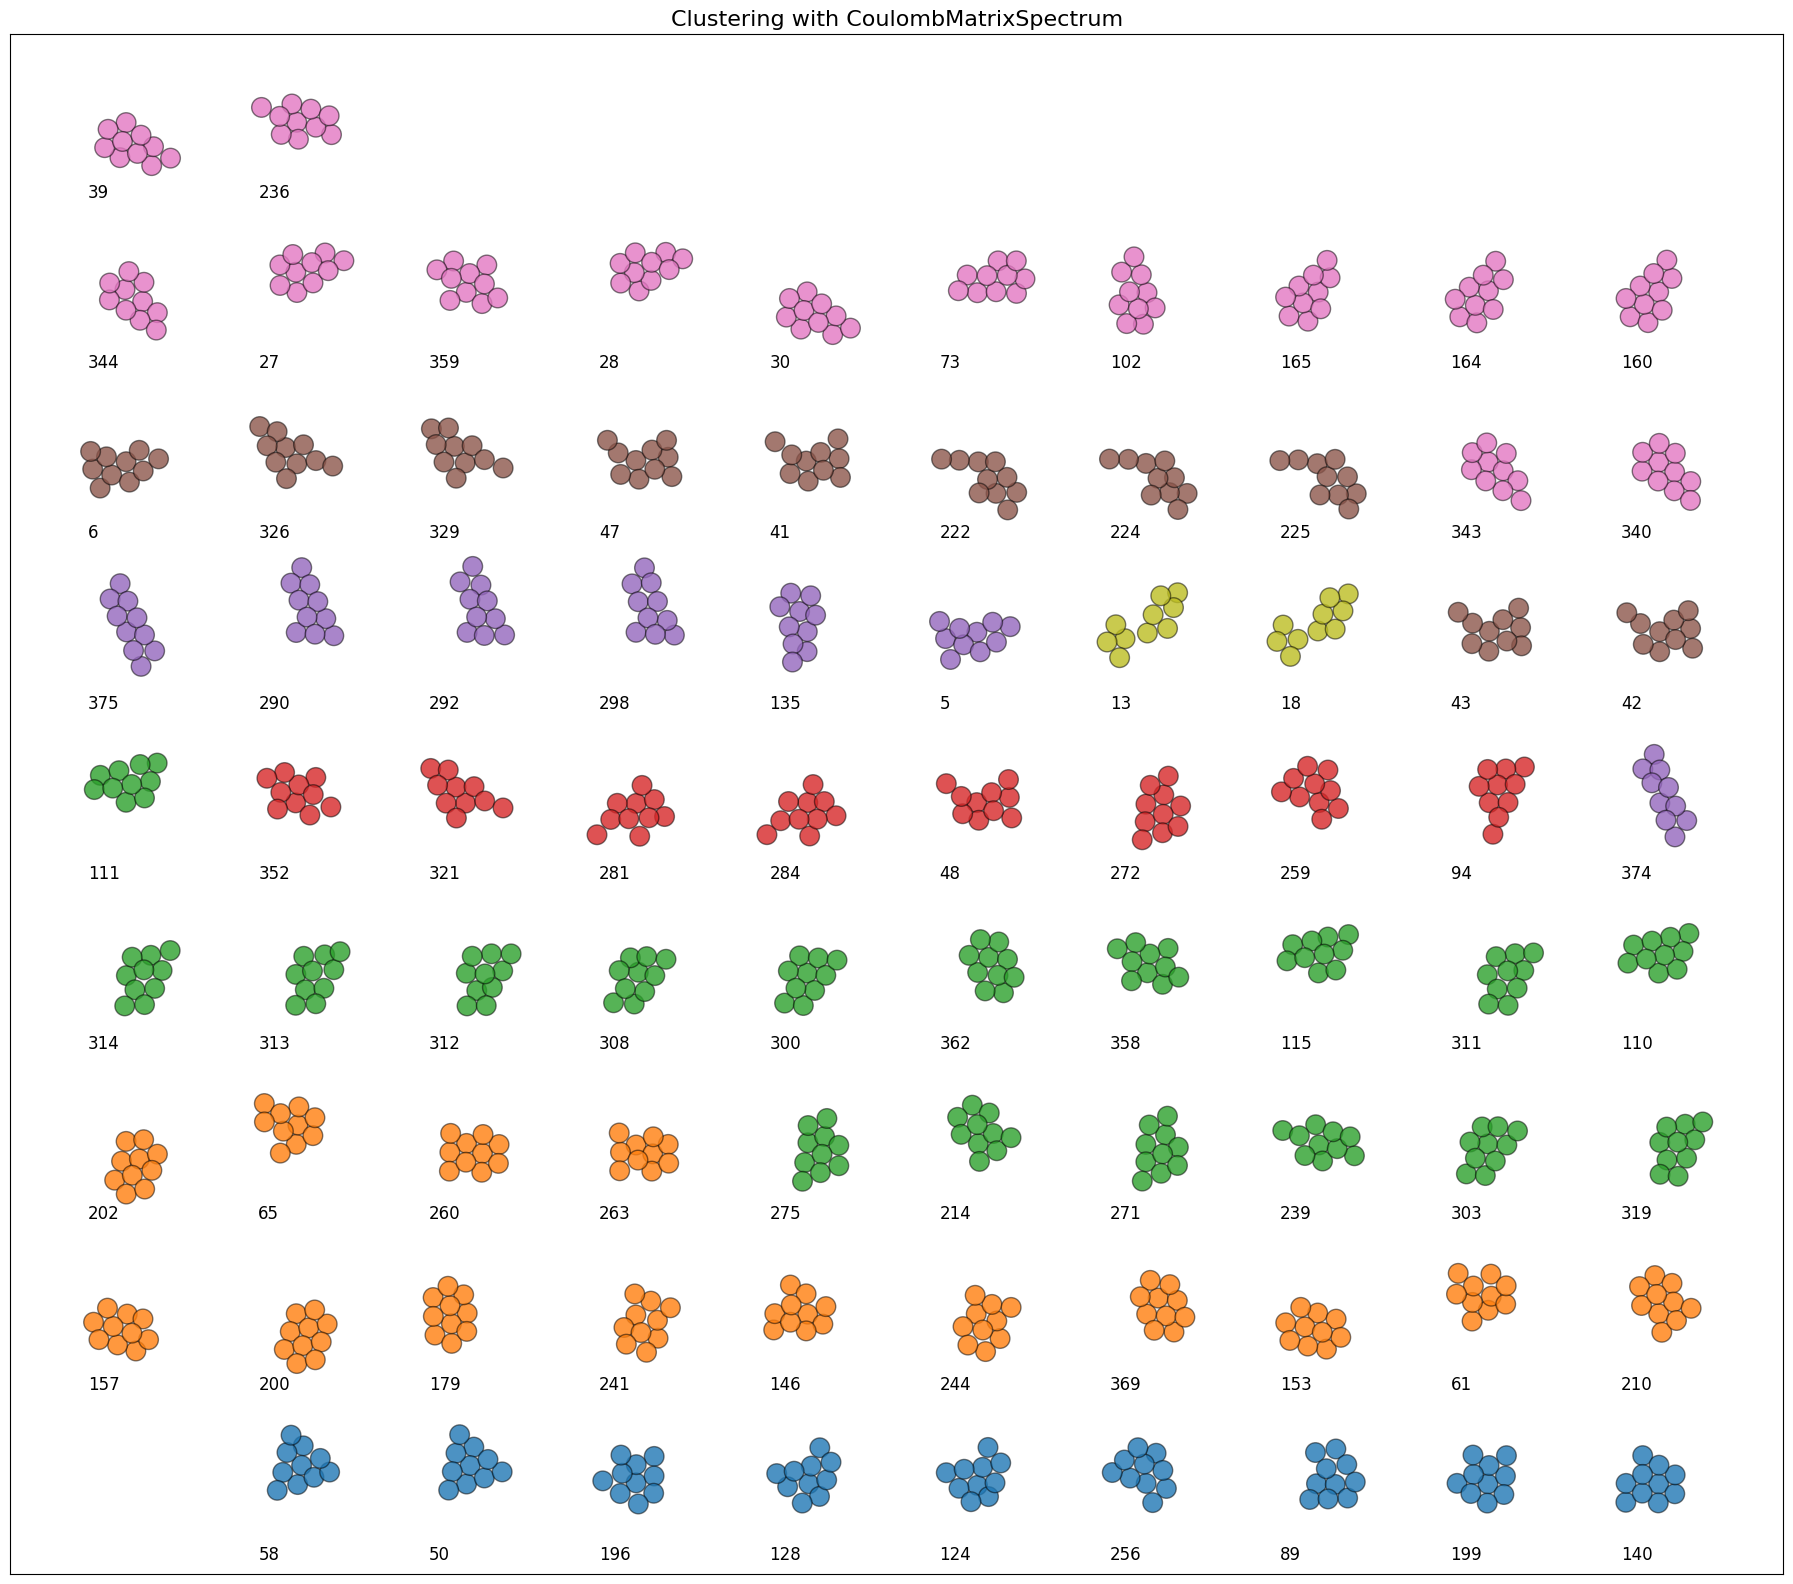

In [110]:


fig, ax = plt.subplots(figsize=(24,20))
a = 10
sorted_indices = [int(i) for i in np.argsort(labels)]
#sorted_indices = range(len(clusters))
disps = {}
i = 0
for _,(atomic_cluster,cluster,j) in enumerate(zip(np.array(rattled_atomic_clusters)[sorted_indices],
                                      labels[sorted_indices],sorted_indices)):
    if np.random.rand() < 0.8:
        continue
    i += 1
    atomic_cluster_copy = atomic_cluster.copy()
    disp = disps.get(cluster,0)
    disps[cluster] = disp + 1
    atomic_cluster_copy.set_positions(atomic_cluster.get_positions() + \
                                      9*np.array([(i%a),(i//a)]) +0*np.array([disp,cluster]),
                                ignore_b=True)
    atomic_cluster_copy.draw(ax,size=200,color=cmap(cluster),alpha=0.8,energy_title=False)
    #ax.text(10*(i%a)-2,10*(i//a)-4,str(i) + ':' + str(atomic_cluster.descriptor))
    ax.text(9*(i%a)-2,9*(i//a)-4,str(j))
ax.set_aspect('equal')
ax.set_title('Clustering with ' + atomic_cluster.descriptor_method.__class__.__name__) 
ax.set_xticks([])
ax.set_yticks([])

In [111]:
fig.tight_layout()
save_plot(fig, 'ClusteredCoupledMatrixSpectrum + PCA + KMeans.png')